# Convergence of spherical harmonic expansion 

This notebook tests how many spherical harmonics need to be included in the sum over basis functions, to meet some desired precision goal. The example is the velocity distribution from arXiv:2310.01483, which is a sum of four gaussians of varying widths. The widest gaussian is well described by the ell=0,1,...6 harmonics, while the narrowest gaussian requires ell=60 for percent-level accuracy.

An analytic result (the plane-wave expansion of the exponential of a dot product) is used to find <g|lm>, the projection of a gaussian function 'g' onto the spherical harmonic basis (|lm>). This <g|lm> is a function of the radial coordinate, which in this example is the DM speed 'u'. 

In [1]:
import math
import numpy as np
import scipy.special as spf
import vegas # numeric integration
import gvar # gaussian variables; for vegas
import time
import quaternionic # For rotations
# import spherical #For Wigner D matrix
# import csv # file IO for projectFnlm
# import os.path
import h5py # database format for mathcalI arrays
import importlib
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as clr

sys.path.insert(0,'../') #load the local version of vsdm
# sys.path.append('../')

import vsdm
from vsdm.units import *
from vsdm.utilities import *
vsdm.__version__

'0.3.3'

In [2]:
"""Analytic result for comparison (radial function).

    The function f is a sum of gaussians, 

        f = sum_i c_i g_i.

    The function <g_i|lm> = integral(dOmega Y_lm(theta, phi) g_i(u,theta,phi)) 
    is given as a function of u by g_i_lm. 
"""

def g_i_lm(gvec, ell, m, u):
    # No factor of u0**3. g_i has units of 1/sigma**3. 
    (ci, vWsph_i, sigma_i) = gvec
    (ui, theta_i, phi_i) = vWsph_i
    cY_i = ci * ylm_real(ell, m, theta_i, phi_i) / sigma_i**3
    factExp = math.exp(-(u-ui)**2/sigma_i**2)
    z = 2*u*ui/sigma_i**2
    if z==0:
        if ell==0:
            factIve = 4/math.sqrt(math.pi)
        else:
            factIve = 0
    else:
        factIve = math.sqrt(8/z) * spf.ive(ell+0.5, z)
    return cY_i * factExp * factIve

def gsum_lm(glist, ell, m, u):
    out = 0.0
    for gvec in glist:
        out += g_i_lm(gvec, ell, m, u)
    return out

def gaussian_stream_sum(ci, vWsph_i, sigma_i):
    # Arguments: lists of amplitudes gi, dispersions v0_i, and 
    #     lab-frame DM wind vectors vWsph_i, in spherical coordinates
    gvec_list = []
    for i in range(len(gi)):
        gaus = (ci[i], vWsph_i[i], sigma_i[i])
        gvec_list += [gaus]
    return gvec_list 

# Define a function to convert GaussianF(gX) into GaussianF(tilde_gX),
# for dimensionless function tilde_gX = u0**3 * gX,
# where u0 is the vsdm.Basis.u0 scale factor
def gX_to_tgX(gauF, u0):
    tgauF_vecs = gauF.rescaleGaussianF(u0**3)
    return vsdm.Gnli(gauF.basis, tgauF_vecs)


## Function: Gaussian Sum

In [3]:
"""
    Model 4: a velocity distribution gX that is the sum of four gaussian streams.
    Stream 0: an SHM-like halo, with dispersion v0 = 220 km/s, infinite escape velocity,
        centered at vX = (0, 0, -230 km/s).
    Streams 1-3: off-axis streams of decreasing velocity dispersion.

    * Each gaussian is proportional to exp( -(u - u_i)**2 / v0**2), 
        where u_i is the 'DM wind velocity'. 

    gvec_tilde_4 is a normalized and dimensionless version of the sum of the four streams.
"""

v0_main = 220*km_s
v0_a = 70*km_s
v0_b = 50*km_s
v0_c = 25*km_s
vX_main = cart_to_sph((0, 0, -230*km_s))
vX_a = cart_to_sph((80*km_s, 0, -80*km_s))
vX_b = cart_to_sph((-120*km_s, -250*km_s, -150*km_s))
vX_c = cart_to_sph((50*km_s, 30*km_s, -400*km_s))
sigma_i = [v0_main, v0_a, v0_b, v0_c]
vWsph_i = [vX_main, vX_a, vX_b, vX_c]
gi = [0.4, 0.3, 0.2, 0.1]
# gi = [0.4, 0.3, 0.2, 0.0]
# gi = [0.4, 0.0, 0.0, 0.0]
# gi = [0.0, 0.0, 0.0, 0.1]
gvec_list_4 = gaussian_stream_sum(gi, vWsph_i, sigma_i)

VMAX = 960.*km_s # Global value for v0=vMax for wavelets
bdict = dict(u0=VMAX, type='wavelet', uMax=VMAX)
gXmodel_4 = vsdm.Gnli(bdict, gvec_list_4)
gtilde_4 = gX_to_tgX(gXmodel_4, VMAX)
gvec_tilde_4 = gtilde_4.gvec_list

tildeE = gtilde_4.norm_energy()

In [4]:
unisize = 3.5 # setting a uniform plot width

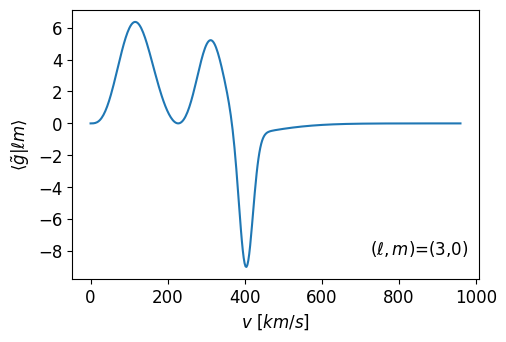

In [5]:
"""
    Plot the radial function <g|lm> for a specific (l,m) mode:
"""
plotpoints = 401
x = np.array([i/plotpoints for i in range(plotpoints+1)])

(ell, m) = (3, 0)
ur = np.array([xi*VMAX for xi in x])
g4_lm = np.array([gsum_lm(gvec_tilde_4, ell, m, u) for u in ur])


plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(ur/km_s, g4_lm)
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel(r'$ \langle\tilde{g}|\ell m\rangle$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell,m)  
plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            verticalalignment='bottom', fontsize=12)
plt.show() 

# Angular Convergence

In [6]:
ellMax = 120
ells = [l for l in range(ellMax+1)]

plotpoints = 401
x = np.linspace(0, 1, plotpoints)
ur = np.array([xi*VMAX for xi in x])

# Evaluate <g|lm> for this list of 'u' values:

g4y = {}
g4y2_u2 = {}
for ell in ells:
    for m in range(-ell, ell+1):
        lm = (ell, m)
        g4y[lm] = np.array([gsum_lm(gvec_tilde_4, ell, m, u) 
                            for u in ur])
        g4y2_u2[lm] = np.array([(ur[i]/VMAX)**2*g4y[lm][i]**2 
                                  for i in range(len(ur))])



In [7]:
"""
    Preparing three sets of plots: starting from a point (u_0, theta_0, phi_0), 
        vary either u, or theta, or phi. 
    These examples use the center of the narrowest gaussian, Stream #3. 

    g4sum_l[ell] is the cumulative sum of all (l,m) modes with l <= ell.
    In the 'ell -> infinity' limit, it should match the original function, gtilde_4.gU.
"""

g4sum_l = {}
gv3 = gvec_list_4[3]
(ci, uSphi, sigmai) = gv3
(u_0, theta_0, phi_0) = (uSphi[0], uSphi[1], uSphi[2])
g4sum_l[0] = ylm_real(0,0,theta_0,phi_0) * g4y[0,0]
for ell in ells[1:]:
    newterms = np.zeros_like(ur)
    for m in range(-ell, ell+1):
        lm = (ell, m)
        newterms += ylm_real(ell, m, theta_0, phi_0) * g4y[lm] 
    g4sum_l[ell] = g4sum_l[ell-1] + newterms
g4sum_l['inf'] = np.array([gtilde_4.gU((u, theta_0, phi_0)) 
                           for u in ur])

g_theta = {}
g_phi = {}
gsum_theta = {}
gsum_phi = {}
thetas = np.array([xi*np.pi for xi in x])
phis = np.array([xi*2*np.pi for xi in x])
# l=0 first:
glm = gsum_lm(gvec_tilde_4, 0, 0, u_0)
g_theta[0] = glm * np.array([ylm_real(0,0,theta,phi_0) for theta in thetas])
g_phi[0] = glm * np.array([ylm_real(0,0,theta_0,phi) for phi in phis])
gsum_theta[0] = g_theta[0]
gsum_phi[0] = g_phi[0]
for ell in ells[1:]:
    new_thetas = np.zeros_like(thetas)
    new_phis = np.zeros_like(phis)
    for m in range(-ell, ell+1):
        glm = gsum_lm(gvec_tilde_4, ell, m, u_0) 
        new_thetas += glm * np.array([ylm_real(ell,m,theta,phi_0) for theta in thetas])
        new_phis += glm * np.array([ylm_real(ell,m,theta_0,phi) for phi in phis])
    g_theta[ell] = new_thetas
    g_phi[ell] = new_phis
    gsum_theta[ell] = new_thetas + gsum_theta[ell-1]
    gsum_phi[ell] = new_phis + gsum_phi[ell-1]

gsum_theta['inf'] = np.array([gtilde_4.gU((u_0, theta, phi_0)) for theta in thetas])
gsum_phi['inf'] = np.array([gtilde_4.gU((u_0, theta_0, phi)) for phi in phis])
#

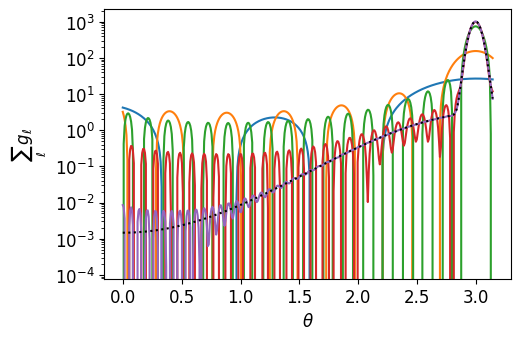

In [8]:
"""
    This plot compares the exact value of gX(v, theta, phi) [dotted black line] 
    to the spherical harmonic expansion, truncated at various values of ellMax. 
    Here v = v0 and phi = phi0 are kept fixed, while theta is varied from 0 to pi. 
    This arc in velocity space passes through the center of the narrowest gaussian.
"""

plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(
         thetas, gsum_theta[4], 
         thetas, gsum_theta[12], 
         thetas, gsum_theta[36], 
         thetas, gsum_theta[60], 
         thetas, gsum_theta[90], 
)
plt.plot(thetas, gsum_theta['inf'], color='black', linestyle='dotted')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel(r'$\sum_\ell \,g_{\ell}$', fontsize=12)
plt.xscale('linear')
plt.yscale('log')
# plt.yscale('linear')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show() 

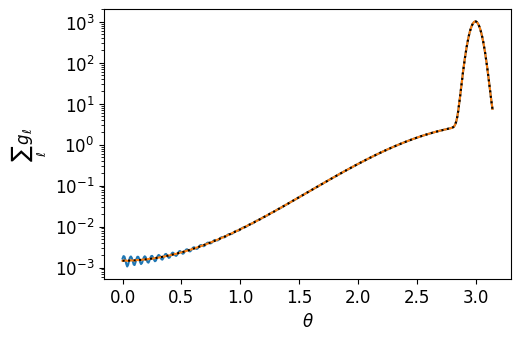

In [9]:
"""
    By l=105, the only noticeable deviations in the harmonic expansion 
        are on the tail of the distribution, near theta=0. 
    By l=120, the deviations are no longer large enough to see by eye.
"""

plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(
         thetas, gsum_theta[105], 
         thetas, gsum_theta[120], 
)
plt.plot(thetas, gsum_theta['inf'], color='black', linestyle='dotted')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel(r'$\sum_\ell \,g_{\ell}$', fontsize=12)
plt.xscale('linear')
plt.yscale('log')
# plt.yscale('linear')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show() 

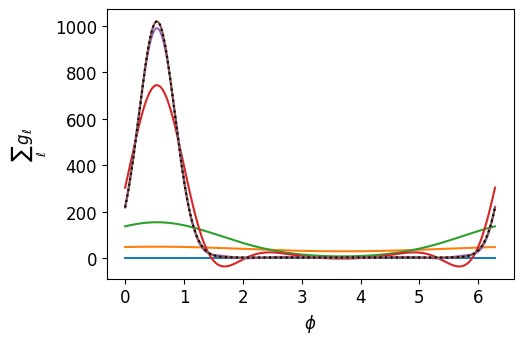

In [10]:
"""
    This plot shows a similar comparison of gX with its spherical harmonic expansion, 
    but varying phi while keeping theta=theta0 fixed.
"""

plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(
         phis, gsum_phi[0], 
         phis, gsum_phi[6], 
         phis, gsum_phi[12], 
         phis, gsum_phi[36], 
         phis, gsum_phi[60], 
         phis, gsum_phi[120], 
)
plt.plot(phis, gsum_phi['inf'], color='black', linestyle='dotted')
plt.xlabel(r'$\phi$', fontsize=12)
plt.ylabel(r'$\sum_\ell \,g_{\ell}$', fontsize=12)
plt.xscale('linear')
plt.yscale('linear')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show() 

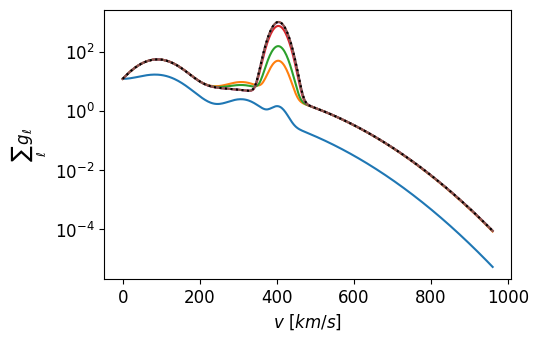

In [11]:
"""
    Same plot of gX(u, theta, phi), varying u.
"""


plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(
         ur/km_s, g4sum_l[0], 
         ur/km_s, g4sum_l[6], 
         ur/km_s, g4sum_l[12], 
         ur/km_s, g4sum_l[36], 
         ur/km_s, g4sum_l[60], 
         ur/km_s, g4sum_l[90])
plt.plot(ur/km_s, g4sum_l['inf'], color='black', linestyle='dotted')
# plt.plot(ur/km_s, sum120, color='red', linestyle='dashed')
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel(r'$\sum_\ell \,g_{\ell}$', fontsize=12)
plt.xscale('linear')
plt.yscale('log')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell,m)  
# plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            # verticalalignment='bottom', fontsize=12)
plt.show() 

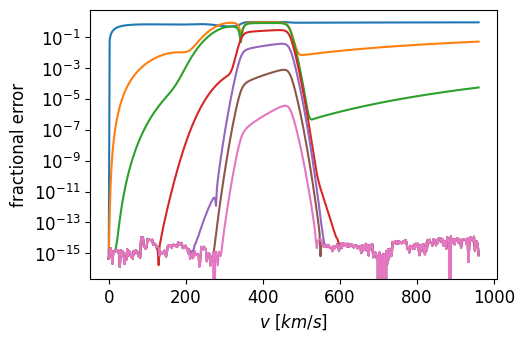

In [12]:
"""
    Local fractional error, as a function of speed v. 
"""

plt.figure(figsize=[1.5*unisize,unisize])
plt.plot(
         ur/km_s, np.abs(g4sum_l[0] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[6] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[12] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[36] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[60] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[90] - g4sum_l['inf'])/g4sum_l['inf'], 
         ur/km_s, np.abs(g4sum_l[120] - g4sum_l['inf'])/g4sum_l['inf'], 
         )
plt.xlabel(r'$v~[km/s]$', fontsize=12)
plt.ylabel('fractional error', fontsize=12)
plt.xscale('linear')
plt.yscale('log')
# plt.title(r'$H = \mathcal{H}/a$ vs proper time')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# labeltext = r'$(\ell, m)$=' + '({},{})'.format(ell,m)  
# plt.figtext(0.88, 0.17, labeltext, horizontalalignment='right',
            # verticalalignment='bottom', fontsize=12)
plt.show() 

In [13]:
ellBig = 60
ellVeryBig = 90
ellVeryVeryBig = 120


In [14]:
g4y_l = {}
g4y2_u2_l = {}
# for ell in ells+[ellBig,ellVeryBig,ellVeryVeryBig]:
for ell in ells:
    sum_m = 0.0
    sum2_m = 0.0
    for m in range(-ell, ell+1):
        lm = (ell,m)
        sum_m += g4y[lm]
        sum2_m += g4y2_u2[lm]
    g4y_l[ell] = sum_m
    g4y2_u2_l[ell] = sum2_m

## Angular Plots

/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/1207407781.py:52: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmap,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/1207407781.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


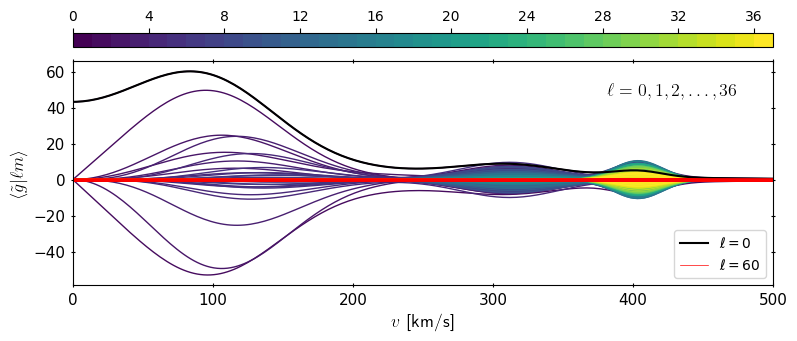

In [15]:
"""
    Plot of the harmonic modes <g|lm>, as a function of speed u.
    Color-coding shows that the Streams #0 and #1 are well described by
        the smaller l < 8; Stream #2 requires l~20; and Stream #3 needs l>36. 
"""

ellMin = 0
ellMax = 36
ells = [l for l in range(ellMin, ellMax+1)]

intervell = np.linspace(0, 1, len(ells))
colorell = [plt.cm.viridis(x) for x in intervell]

fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax.set_ylabel(r'$\langle\tilde{g}|\ell m\rangle$', 
              fontsize=13, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax.plot(ur/km_s, g4y[(ell,m)], color=colorell[i],
                linewidth=1)

ax.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$')
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=0.5)
    else:        
        ax.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                linewidth=1)
    
ax.tick_params(axis='both', labelsize=11, direction='inout',
               right=True, top=True)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax.text(0.95, 0.9, labeltext, horizontalalignment='right',
        verticalalignment='top', fontsize=13, 
        transform=ax.transAxes, usetex=True)
ax.set_xlim([0,500])
ax.legend(loc='lower right')


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)

fig.show() 


/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/2151718604.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmap,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/2151718604.py:87: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


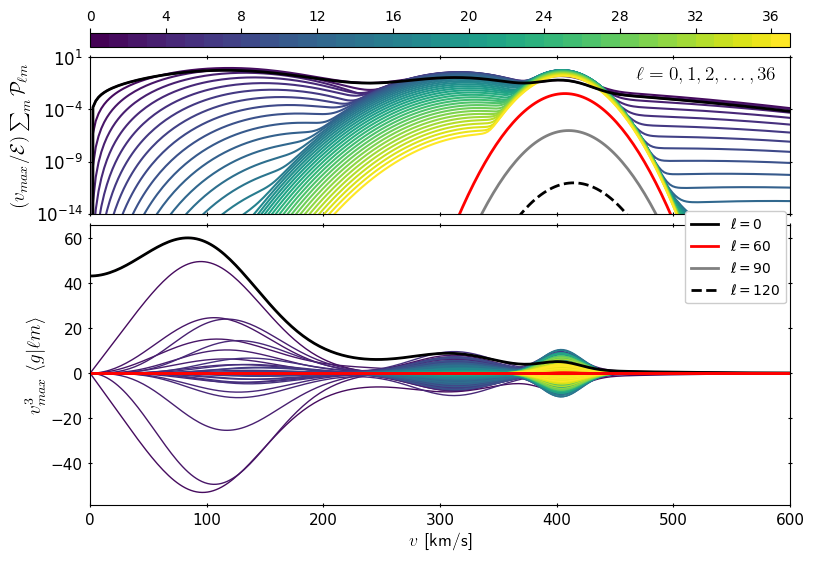

In [16]:
"""
    Two-panel figure, with the previous figure above, and the 
        distributional power P_l(u) in the lower panel.

    The result: Streams 0,1,2 are converging by l~30, but Stream #3 needs l~60 or better,
        e.g. to get percent-level accuracy on the reconstructed function.

"""


fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])

vlim = [0,600]
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax1.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax1.set_ylabel(r'$v_{max}^3\ \langle g|\ell m\rangle$', 
               fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax1.plot(ur/km_s, g4y[(ell,m)], color=colorell[i], 
                 linewidth=1)

ax1.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$',
         linewidth=2)
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=1)
    else:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                 linewidth=1)
    
ax1.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=True, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, 36$'  
ax1.set_xlim(vlim)

ax_Pl = fig.add_axes([0,1.04,1,0.7], xscale='linear', yscale='log')
ax_Pl.set_ylabel(r'$(v_{max}/\mathcal E) \sum_m  \mathcal P_{\ell m}$', 
              fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_Pl.plot(ur/km_s, g4y2_u2_l[ell]/tildeE, 
               color=colorell[i])

ax_Pl.plot(ur/km_s, g4y2_u2_l[0]/tildeE, 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellBig]/tildeE, 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_Pl.plot(ur/km_s, 
           g4y2_u2_l[ellVeryBig]/tildeE, 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellVeryVeryBig]/tildeE, 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)
    
ax_Pl.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax_Pl.text(0.98, 0.94, labeltext, horizontalalignment='right',
           verticalalignment='top', fontsize=14, 
           transform=ax_Pl.transAxes, usetex=True)
ax_Pl.set_xlim(vlim)
ax_Pl.set_ylim([1e-14,10])
# ax_Pl.set_yticks([1e-12,1e-9,1e-6,1e-3,1])
ax_Pl.legend(loc=[0.85,-0.57], framealpha=1)


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)
fig.show() 




/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/652774618.py:127: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(mappable=clmap,
/var/folders/9f/0fs4y5917_q6nlh99_p3shbw0000gn/T/ipykernel_71897/652774618.py:132: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


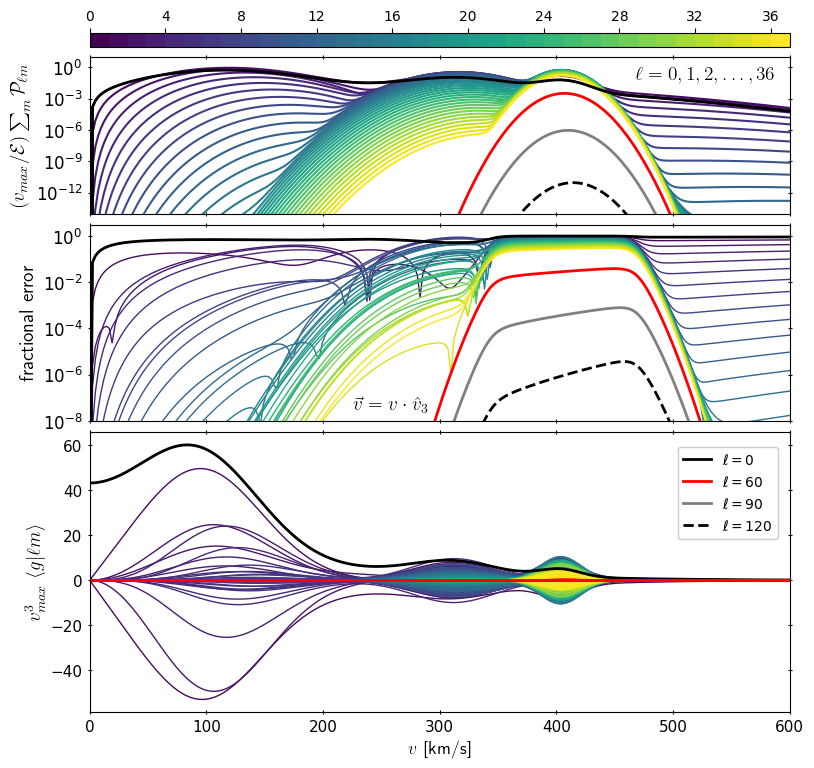

In [17]:
"""
    Previous plot, with a new middle panel showing the fractional error,
    between the sum_lm( <g|lm> * Y_lm(theta, phi) ) and the exact result, g(u, theta, phi). 
    This fractional error plot evaluates the velocity along a fixed theta_0, phi_0 ray, 
        with (theta_0, phi_0) pointing towards the center of the narrowest gaussian.
"""


ellMin = 0
ellMax = 36
ells = [l for l in range(ellMin, ellMax+1)]

intervell = np.linspace(0, 1, len(ells))
colorell = [plt.cm.viridis(x) for x in intervell]

fig = plt.figure(figsize=[2.0*unisize,0.8*unisize])

vlim = [0,600]
"""Wavelet: Function values"""
xtix = [0,100,200,300,400,500,600,700,800,900,960]
ax1 = fig.add_axes([0,0,1,1], xscale='linear', yscale='linear')
# ax.set_xticks(xtix)
ax1.set_xlabel(r'$v$ [km/s]', fontsize=13, usetex=True)
ax1.set_ylabel(r'$v_{max}^3\ \langle g|\ell m\rangle$', 
               fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    for m in range(-ell, ell+1):
        ax1.plot(ur/km_s, g4y[(ell,m)], color=colorell[i], 
                 linewidth=1)

ax1.plot(ur/km_s, g4y[(0,0)], color='black', label=r'$\ell=0$',
         linewidth=2)
for m in range(-ellBig, ellBig+1):
    if m==0:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                label=r'$\ell={}$'.format(ellBig), linewidth=1)
    else:        
        ax1.plot(ur/km_s, g4y[(ellBig,m)], color='red', 
                 linewidth=1)
    
ax1.tick_params(axis='both', labelsize=11, direction='inout',
                right=True, top=True,  
                labelbottom=True, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, 36$'  
ax1.set_xlim(vlim)


ax_rel = fig.add_axes([0,1.04,1,0.7], xscale='linear', yscale='log')
ax_rel.set_ylabel('fractional error', 
                  fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_rel.plot(ur/km_s, 
                np.abs(g4sum_l['inf']-g4sum_l[ell])/g4sum_l['inf'], 
                color=colorell[i],
                linewidth=1)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[0])/g4sum_l['inf'], 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellBig])/g4sum_l['inf'], 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellVeryBig])/g4sum_l['inf'], 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_rel.plot(ur/km_s, 
           np.abs(g4sum_l['inf']-g4sum_l[ellVeryVeryBig])/g4sum_l['inf'], 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)

ax_rel.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\vec v = v \cdot \hat{v}_3$'  
ax_rel.text(0.43, 0.04, labeltext, horizontalalignment='center',
            verticalalignment='bottom', fontsize=14, 
            transform=ax_rel.transAxes, usetex=True)
ax_rel.set_xlim(vlim)
ax_rel.set_ylim([1e-8, 3])
ax_rel.legend(loc=[0.84,-0.6], framealpha=1)



ax_Pl = fig.add_axes([0,1.78,1,0.7], xscale='linear', yscale='log')
ax_Pl.set_ylabel(r'$(v_{max}/\mathcal E) \sum_m  \mathcal P_{\ell m}$', 
              fontsize=14, usetex=True)
for i,ell in enumerate(ells):
    ax_Pl.plot(ur/km_s, g4y2_u2_l[ell]/tildeE, 
               color=colorell[i])

ax_Pl.plot(ur/km_s, g4y2_u2_l[0]/tildeE, 
           color='black', label=r'$\ell=0$',
           linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellBig]/tildeE, 
           color='red', 
           label=r'$\ell={}$'.format(ellBig), linewidth=2)
ax_Pl.plot(ur/km_s, 
           g4y2_u2_l[ellVeryBig]/tildeE, 
           color='gray', 
           label=r'$\ell={}$'.format(ellVeryBig), linewidth=2)
ax_Pl.plot(ur/km_s, g4y2_u2_l[ellVeryVeryBig]/tildeE, 
           color='black', linestyle='dashed',
           label=r'$\ell={}$'.format(ellVeryVeryBig), linewidth=2)
    
ax_Pl.tick_params(axis='both', labelsize=12, direction='inout',
                  right=True, top=True, 
                  labelbottom=False, labeltop=False)

labeltext = r'$\ell = 0, 1, 2, \ldots, {}$'.format(ellMax)  
ax_Pl.text(0.98, 0.94, labeltext, horizontalalignment='right',
           verticalalignment='top', fontsize=14, 
           transform=ax_Pl.transAxes, usetex=True)
ax_Pl.set_xlim(vlim)
ax_Pl.set_ylim([1e-14,10])
ax_Pl.set_yticks([1e-12,1e-9,1e-6,1e-3,1])


cnorm = plt.Normalize(vmin=ellMin, vmax=ellMax)
boundaries = np.array(ells)
boundaries = np.append(boundaries, boundaries[-1] + 1)
clmap = plt.cm.ScalarMappable(norm=cnorm, cmap='viridis')

fig.colorbar(mappable=clmap,  
             boundaries=boundaries, values=ells,
             orientation='horizontal', location='top', 
             aspect=50)
plt.savefig('out/g_lm_36.pdf', format="pdf", bbox_inches='tight')
fig.show() 




For tests of the convergence of the radial basis function expansion in wavelets, see the "Plots_Radial" notebook.  